# Using Traditional Aproach

In [1]:
import pandas as pd
import numpy as np
import cv2
import pytesseract
custom_config = r'— oem 3 — psm 6' 
from matplotlib import pyplot as plt


pytesseract.pytesseract.tesseract_cmd = r'D:\Work Station\Tesseract\tesseract.exe'

In [4]:
base_dir = "./Data/"

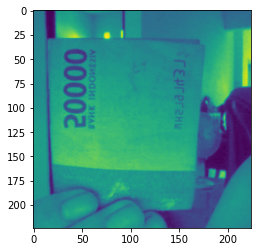

In [132]:
# load raw image
img = cv2.imread(base_dir+"50K-samples/0.jpg",0)

# display raw image
plt.imshow(img)
plt.show()

In [133]:
# Sharpen the Image

def sharpen_image(im):
  kernel = np.ones((3,3),np.float32)/90
  im = cv2.filter2D(im,-1,kernel)
  return im

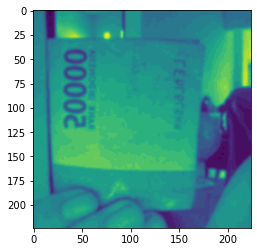

In [134]:
img = sharpen_image(img)
# display sharpened image
plt.imshow(img)
plt.show()

seem better without sharpen :3

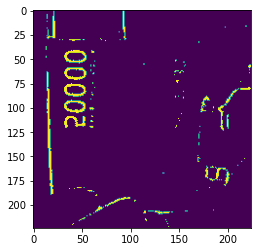

In [135]:
# apply image thresholding
img_thresh = cv2.adaptiveThreshold(img,    
          255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
# invert the image, 255 is the maximum value
img_thresh = 255 - img_thresh
# display image
plt.imshow(img_thresh)
plt.show()

88.8426742553711


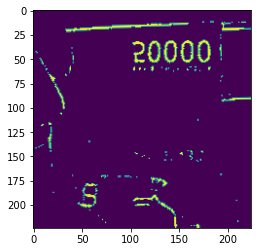

In [136]:
def align_text(im):
  coords = np.column_stack(np.where(img_thresh > 0))
  angle = cv2.minAreaRect(coords)[-1]
  print(angle)
  if angle < -45:
    angle = -(90 + angle)
  else:
    angle = -angle
  h,w = img.shape
  center = (w // 2, h // 2)
  
  M = cv2.getRotationMatrix2D(center, angle, 1.0)
  rotated = cv2.warpAffine(img_thresh, M, (w, h),
            flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
  return rotated
# align image text
img = align_text(img)
# display rotated and aligned image
plt.imshow(img)
plt.show()

In [137]:
# split text into rows
# find sum of column values, row-wise
a = np.sum(img == 255, axis=1)
rows = []
seg = []
for i in range(len(a)):
  if a[i] > 0:
    seg.append(i)
  if (a[i] == 0) & (len(seg) >= 5):
    rows.append(seg)
    seg = []
  if len(seg) > 0:
    rows.append(seg)
# number of row segments
len(rows)

184

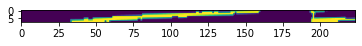

In [138]:
plt.imshow(img[rows[0][0]:rows[0][-1],:])
plt.show()

In [139]:
for i in range(len(rows)):
  a = pytesseract.image_to_string(img[rows[i][0]:rows[i][-1],:],config=custom_config,lang='ind')
  if len(a) > 0:
    print(a) 

## Summary
- Traditional Aproach seems doesnt really good :'

# Using Deep Learning Aproach

In [1]:
'''Restart Kernel to proceed'''

import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# %matplotlib inline

In [2]:
base_dir = "Data"

In [3]:
import splitfolders

splitfolders.ratio(base_dir,output="output",seed=1337,ratio=(.7,.2,.1))

In [4]:
import os
new_dir = 'output'
train_dir = os.path.join(new_dir,'train')
val_dir = os.path.join(new_dir,'val')
test_dir = os.path.join(new_dir,'test')

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    vertical_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')
 
test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

In [27]:
train_generator = train_datagen.flow_from_directory(
        train_dir,  # direktori data latih
        target_size=(256, 256),  # mengubah resolusi seluruh gambar menjadi 256x256 piksel
        batch_size=16,
        color_mode= 'rgb',
        class_mode='binary')
 
validation_generator = test_datagen.flow_from_directory(
        val_dir, # direktori data validasi
        target_size=(256, 256), # mengubah resolusi seluruh gambar menjadi 256x256 piksel
        batch_size=16,
        color_mode= 'rgb',
        class_mode='binary')

Found 196 images belonging to 2 classes.
Found 56 images belonging to 2 classes.


In [31]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [32]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [33]:
fitted_model = model.fit(
      train_generator,
      epochs=25, # tambahkan eposchs jika akurasi model belum optimal
      validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
      validation_steps=5,  # berapa batch yang akan dieksekusi pada setiap epoch
      verbose=2)

Epoch 1/25
13/13 - 12s - loss: 0.8135 - accuracy: 0.6122 - val_loss: 0.5693 - val_accuracy: 0.6071
Epoch 2/25
13/13 - 10s - loss: 0.3803 - accuracy: 0.8061
Epoch 3/25
13/13 - 10s - loss: 0.2353 - accuracy: 0.9133
Epoch 4/25
13/13 - 10s - loss: 0.1826 - accuracy: 0.9388
Epoch 5/25
13/13 - 10s - loss: 0.2735 - accuracy: 0.9082
Epoch 6/25
13/13 - 11s - loss: 0.1934 - accuracy: 0.9388
Epoch 7/25
13/13 - 9s - loss: 0.1210 - accuracy: 0.9592
Epoch 8/25
13/13 - 9s - loss: 0.1318 - accuracy: 0.9643
Epoch 9/25
13/13 - 10s - loss: 0.1166 - accuracy: 0.9643
Epoch 10/25
13/13 - 10s - loss: 0.0874 - accuracy: 0.9745
Epoch 11/25
13/13 - 10s - loss: 0.0590 - accuracy: 0.9898
Epoch 12/25
13/13 - 10s - loss: 0.1250 - accuracy: 0.9694
Epoch 13/25
13/13 - 9s - loss: 0.0529 - accuracy: 0.9847
Epoch 14/25
13/13 - 9s - loss: 0.1196 - accuracy: 0.9643
Epoch 15/25
13/13 - 10s - loss: 0.2013 - accuracy: 0.9133
Epoch 16/25
13/13 - 10s - loss: 0.1405 - accuracy: 0.9643
Epoch 17/25
13/13 - 10s - loss: 0.2442 - ac

50k


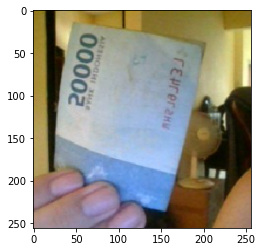

In [43]:
path = base_dir+"/50K-samples/99.jpg"
img = image.load_img(path, target_size=(256,256))
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)

# print(fn)
if classes==0:
    print('10k')
else:
    print('50k')